In [1]:
import math
import time

import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
train_x = torch.linspace(0, 1, 20)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

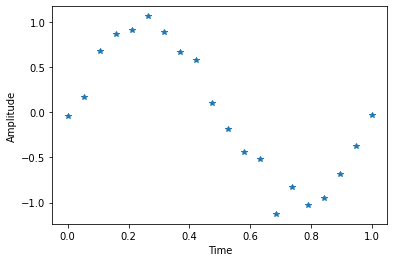

In [3]:
plt.plot(train_x, train_y, '*')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [5]:
test_x = torch.linspace(0, 1, 100)

model.eval()
likelihood.eval()

test_x.requires_grad_(True)

with torch.no_grad():
    observed_pred = likelihood(model(test_x))
    %time y_samples = observed_pred.rsample()

CPU times: user 1.38 ms, sys: 449 µs, total: 1.83 ms
Wall time: 2.99 ms


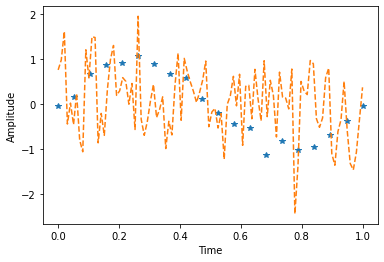

In [6]:
plt.plot(train_x, train_y, '*')
plt.plot(test_x.detach().numpy(), y_samples.numpy(), '--')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [7]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.049   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.024   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.997   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.970   lengthscale: 0.554   noise: 0.554
Iter 5/50 - Loss: 0.941   lengthscale: 0.513   noise: 0.513
Iter 6/50 - Loss: 0.911   lengthscale: 0.474   noise: 0.474
Iter 7/50 - Loss: 0.878   lengthscale: 0.437   noise: 0.438
Iter 8/50 - Loss: 0.841   lengthscale: 0.402   noise: 0.403
Iter 9/50 - Loss: 0.801   lengthscale: 0.370   noise: 0.371
Iter 10/50 - Loss: 0.756   lengthscale: 0.339   noise: 0.341
Iter 11/50 - Loss: 0.710   lengthscale: 0.311   noise: 0.312
Iter 12/50 - Loss: 0.665   lengthscale: 0.284   noise: 0.286
Iter 13/50 - Loss: 0.624   lengthscale: 0.259   noise: 0.261
Iter 14/50 - Loss: 0.589   lengthscale: 0.238   noise: 0.238
Iter 15/50 - Loss: 0.558   lengthscale: 0.219   noise: 0.217
Iter 16/50 - Loss: 0.529   lengthscale: 0.205   noise: 0.197
Iter 17/50 - Loss: 0.500   length

In [73]:
test_x = torch.linspace(0, 1, 100)

model.eval()
likelihood.eval()

test_x.requires_grad_(True)

with torch.no_grad():
    observed_pred = likelihood(model(test_x))
    %time y_samples = observed_pred.rsample()

CPU times: user 868 µs, sys: 10 µs, total: 878 µs
Wall time: 885 µs


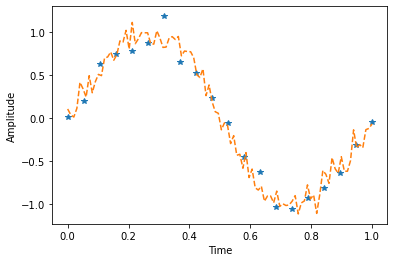

In [74]:
plt.plot(train_x, train_y, '*')
plt.plot(test_x.detach().numpy(), y_samples.numpy(), '--')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

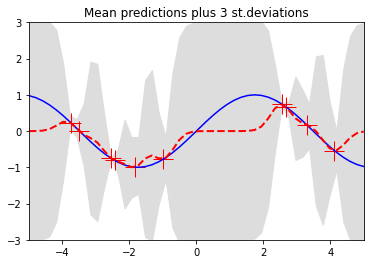

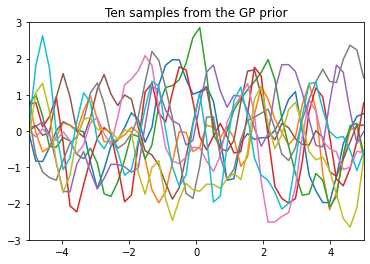

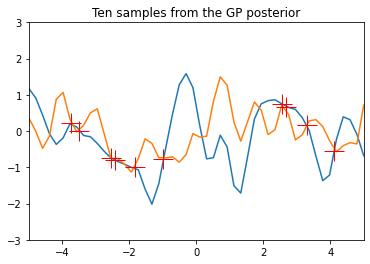

In [77]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl

""" This is code for simple GP regression. It assumes a zero mean GP Prior """


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

N = 10         # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)


# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=20)
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,2)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.plot(X, y, 'r+', ms=20)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()